## Imports

In [16]:
# For OS interaction and system-specific parameters
import os
import sys

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import StepLR

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets


# Albumentations for Data Augmentation
import albumentations as A

# PIL for image operations
from PIL import Image
from PIL import ImageOps

# Matplotlib for plotting and visualizations
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# TensorBoardX - TensorBoard for PyTorch
from tensorboardX import SummaryWriter

# CodeCarbon for tracking our carbon emissions
from codecarbon import EmissionsTracker

# tqdm for showing progress bars
from tqdm.notebook import tqdm

# Add scripts to directory
sys.path.append('C:\\Users\\jacob\\OneDrive\\Desktop\\SyntheticEye\\Development\\scripts')
# Import custom helper functions from the scripts directory
import helper_functions

## Visualize Dimensions of Images in Classes
This helps us with:
- Understanding our data
- Choosing a fixed image size

In [17]:
# Import necessary function from helper_functions.py
from helper_functions import plot_image_dimensions

In [ ]:
# Plotting dimensions of ai-generated images
img_dir = "/Users/jacob/OneDrive/Desktop/image-dataset/dataset_1/Fake"
plot_image_dimensions(img_dir, heading='Fake Image Dimensions')

In [ ]:
# Plotting dimensions of real images
img_dir = "/Users/jacob/OneDrive/Desktop/image-dataset/dataset_1/Real"
plot_image_dimensions(img_dir, heading='Fake Image Dimensions')

## Setup Neural Network Architecture
We will reuse the architecture from our face detection model. This architecture includes convolutional layers with residual blocks, followed by fully connected layers for classification.
This is essential, because we want to utilize transfer learning with our trained face detection model 

In [18]:
class ResBlock(nn.Module):
    """
    A residual block that consists of a convolutional block and a skip connection.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super(ResBlock, self).__init__()
        
        # Define main convolutional block
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob)
        )
        
        # Define skip connection and adapt channels as if needed
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    # Pass input through main block and add skip connection
    def forward(self, x):
        out = self.block(x)
        res = self.residual(x)
        return out + res

class AdjustedResCNN(nn.Module):
    """
    This is an adjusted version of our DeeperDNN with slight adjustments and the addition of skip connections.
    This is the model architecture of our currently deployed face detection model.
    """
    def __init__(self, dropout_prob=0.3):
        super(AdjustedResCNN, self).__init__()

        # Convolutional layers with residual blocks and max-pooling. The dropout probability is reduced for the convolutional layers
        self.conv_layers = nn.Sequential(
            ResBlock(3, 24, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(24, 48, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(48, 96, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(96, 192, dropout_prob * 0.2),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size(), 448),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(448, 224),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(224, 112),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(112, 1) # Final layer with one output for our binary classification problem
        )

    def feature_size(self):
        """
        Compute size of flattend features after passing through the convolutional layers.
        This is useful for determining the input size for the fully connected layers
        """
        return self.conv_layers(torch.zeros(1, 3, 224, 224)).view(1, -1).size(1)

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv_layers(x)
        # Flatten tensor
        x = x.view(x.size(0), -1) 
        # Pass flattened tensor through fully connected layers
        x = self.fc_layers(x)
        return x

## Set Up Device Agnostic Code

In [19]:
# Set the device to GPU if available, else use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Hyperparameters

In [20]:
# Define Hyperparameters
num_classes = 2
learning_rate = 0.001
batch_size = 16
num_epochs = 12

## Data
- Load datasets 
- Split data
- Apply transformations to images and utilize data augmentation

In [21]:
class CustomDataset(Dataset):
    """
    Custom Dataset for loading images with albumentations transforms
    """
    def __init__(self, img_paths, label_list, transform=None):
        self.img_paths = img_paths
        self.label_list = label_list
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        
        # Ensure the image is RGB
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        
        img = np.array(img)
        
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']

        label = self.label_list[index]
        return img, label

### Calculate Mean and Standard Deviation of Images
This is helpful information for normalizing the images

In [7]:
from helper_functions import get_image_mean_std

dataset_path = "/Users/jacob/OneDrive/Desktop/image-dataset/dataset_1"

mean, std = get_image_mean_std(dataset_path)
print(mean)
print(std)

KeyboardInterrupt: 

In [22]:
# Mean and standard deviation for normalization
mean = [0.472, 0.444, 0.403]
std = [0.221, 0.217, 0.212]

### Define Image Transformations
Utilize data augmentation

In [23]:
class AlbumentationsTransform:
    """
    Class to transform images using the Albumentations library
    """
    def __init__(self, transform=None):
        self.transform = transform

    # Apply Albumentations transform to the input image and convert the result to a tensor.
    def __call__(self, img):
        # Convert image to numpy array if needed
        if isinstance(img, Image.Image):
            img = np.array(img)
        
        # Convert augmented image to a tensor and normalize pixel values
        augmented = self.transform(image=img)
        img_tensor = torch.from_numpy(augmented['image'].transpose(2, 0, 1)).float()
        return img_tensor

In [24]:
class TorchvisionBridge:
    """
    Bridge to convert Torchvision transforms into a format that can be used with the Albumentations library.
    """
    def __init__(self, transform):
        self.transform = transform

    # Apply torchvision transformations and convert the results to a numpy array
    def __call__(self, img):
        img = self.transform(img)
        return np.array(img)

In [25]:
# Train Transformations

# Albumentations transformations
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.25),
    A.Rotate(limit=10, p=0.5),
    A.PixelDropout(dropout_prob=0.01, p=0.3),
    A.Normalize(mean=mean, std=std), 
])
# Torchvision transformations
train_torchvision_transform = transforms.Compose([
    transforms.RandomAffine(degrees=2, translate=(0.025, 0.025)), # This helps making the model more robust on mobile (since users usually upload screenshots wich have a different positional format than the actual image), but a high value can weaken the accuracy on desktop (when used in the original image resultion).  
    transforms.Resize((224, 224))  # Resize all images to 224x224
])

# Test Transformations

# Albumentations transformations
test_transform = A.Compose([
    A.Resize(224, 224),
])

# Torchvision transformations
test_torchvision_transform = transforms.Compose([
    transforms.Resize((224, 224))
])

In [26]:
class CustomDataset(Dataset):
    """
    This Custom Dataset class is used to incorporate Torchvision and Albumentation transformations.
    """

    # Initialize CustomDataset Object
    def __init__(self, dataset, torchvision_transforms=None, albumentations_transform=None):
        self.dataset = dataset
        self.torchvision_transforms = torchvision_transforms
        self.albumentations_transform = AlbumentationsTransform(albumentations_transform)

    # Return number of samples in the dataset
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Check if dataset is a subset and get the path and target accordingly
        if isinstance(self.dataset, torch.utils.data.Subset):
            path, target = self.dataset.dataset.samples[self.dataset.indices[index]]
        else:
            path, target = self.dataset.samples[index]
        
        img = Image.open(path).convert("RGB")

        # Apply torchvision transforms if defined
        if self.torchvision_transforms:
            img = self.torchvision_transforms(img)
        
        # Apply albumentations transforms if defined
        if self.albumentations_transform:
            img = self.albumentations_transform(img)
        
        return img, target

In [27]:
root_directory = '/Users/jacob/OneDrive/Desktop/SyntheticEye/Version2_4/Dataset/'

# Load dataset without transformations
full_dataset = datasets.ImageFolder(root=root_directory)

# Set random seed for reproducibility
torch.manual_seed(3)

# Split dataset into train, validation, and test sets
train_size = int(0.85 * len(full_dataset))  # 85%
validation_size = int(0.05 * len(full_dataset))  # 5%
test_size = len(full_dataset) - train_size - validation_size  # 10%

train_subset, validation_subset, test_subset = random_split(full_dataset, [train_size, validation_size, test_size])

# Apply transformations using the CustomDataset class
train_dataset = CustomDataset(
    train_subset, 
    torchvision_transforms=train_torchvision_transform, 
    albumentations_transform=train_transform
)

# Apply transformations to validation dataset
val_dataset = CustomDataset(
    validation_subset, 
    torchvision_transforms=test_torchvision_transform, 
    albumentations_transform=test_transform
)

# Apply transformations to test dataset
test_dataset = CustomDataset(
    test_subset, 
    torchvision_transforms=test_torchvision_transform, 
    albumentations_transform=test_transform
)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Explore and Visualize Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


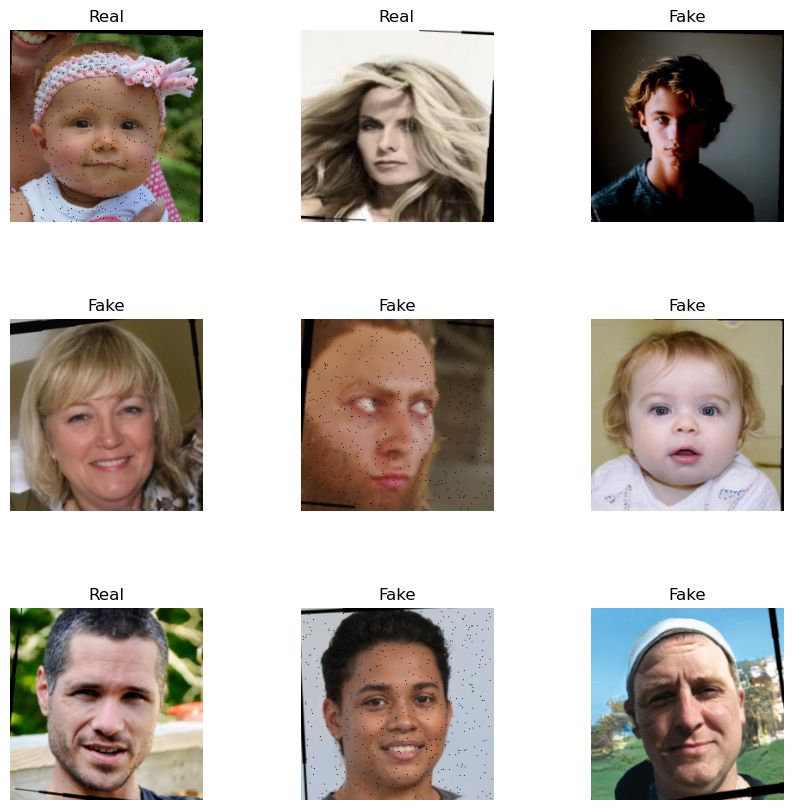

In [28]:
# Show a few images from the train dataset
from helper_functions import show_img
show_img(train_loader, class_names=full_dataset.classes, mean=mean, std=std)

## Training

### Prepare Training

In [ ]:
from helper_functions import check_accuracy

In [ ]:
# Set a random seed for reproducibility
torch.manual_seed(3)

# Initialize model and transfer it to the GPU (if available)
model = AdjustedResCNN().to(device)

In [ ]:
# Use BCEWithLogitsLoss for our binary classification problem
loss_function = nn.BCEWithLogitsLoss()
# Define NAdam (a variant of the Adam optimizer) as our optimizer
optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
# Define learning rate scheduler to adjust our learning rate
scheduler = StepLR(optimizer, step_size=1, gamma=0.94)

In [ ]:
# Initialize TensorBoard summary writer
writer = SummaryWriter(f'runs/Argus1_0')
step = 0

### Check Accuracy of Model

In [ ]:
check_accuracy(test_loader, model, device)